In [1]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModel,
    BitsAndBytesConfig,
    TrainingArguments,
)

/home/ubuntu/data/miniconda3/envs/finetune-gllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-06-03 15:13:02,316] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
import deepspeed
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModel
import torch
from peft import AutoPeftModelForCausalLM, PeftModel

base_dir = "llama-linear-layers-all-conv-Feb-19-24-1"
checkpoint_number = "checkpoint-2500"
checkpoint_path = "{}/{}".format(base_dir, checkpoint_number)
model_name = "NousResearch/Llama-2-7b-chat-hf"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype
)

original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto"
)

peft_model = PeftModel.from_pretrained(original_model, checkpoint_path)
#peft_model = peft_model.merge_and_unload()
restored_tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.25s/it]


In [3]:
#save model to HuggingFace hub
#https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/mixtral-8x7b-for-web-qa.ipynb

In [4]:
# Helpful links

# https://docs.haystack.deepset.ai/docs/custom-components
# https://docs.haystack.deepset.ai/docs/promptbuilder
# https://github.com/deepset-ai/haystack/blob/main/examples/retrievers/in_memory_bm25_documentsearch.py
# https://github.com/deepset-ai/haystack-tutorials/tree/main/tutorials

In [3]:
import requests
import json
import os
import glob
import fnmatch
import pandas as pd
import markdown
from html import unescape
from bs4 import BeautifulSoup
import secrets

from haystack import Document, Pipeline
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.builders.prompt_builder import PromptBuilder

In [4]:
# Collect from GTN

docs = []
directory_path = "../gtn-data/"

def read_md_file_1(path):
    with open(path) as f:
        content = f.read()
        return content

def read_md_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        md_content = file.read()
    return extract_plain_text_from_md(md_content)

def extract_plain_text_from_md(md_content):
    html_content = markdown.markdown(md_content)
    plain_text = ''.join(BeautifulSoup(html_content, "html.parser").findAll(text=True))
    return plain_text.strip()

def generate_hex_id(length):
    random_bytes = secrets.token_bytes(length // 2)
    return random_bytes.hex()
    
#included_content = "/topics/statistics/tutorials/intro_deep_learning/"

included_content = "/topics/"

for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if fnmatch.fnmatch(filename, '*.md'):
            path = os.path.join(root, filename)
            if included_content in path:
                s_path = path.split("/")[-3:]
                tutorial_name = "_".join(s_path)
                md_plain_text = read_md_file(path)
                doc = Document(content=md_plain_text, id=generate_hex_id(10))
                docs.append(doc)

/tmp/ipykernel_69676/3275885192.py:18: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  plain_text = ''.join(BeautifulSoup(html_content, "html.parser").findAll(text=True))


In [17]:
len(docs)

1390

In [5]:
# Collect from PRs
# process PRs
for json_file in glob.glob("../out/github_pr_page_*.json"):
    with open(json_file, "r") as fin:
        doc_json = json.load(fin)
        for pr in doc_json:
            pr_text = pr["body"]
            if pr_text != None:
                useful_text_limit = pr_text.find("## How to test the changes")
                if useful_text_limit > 0:
                    pr_text = pr_text[:useful_text_limit].strip()
                    doc = Document(content=pr_text, id=generate_hex_id(10))
                    docs.append(doc)

In [6]:
docs[:5]

[Document(id=b615a73ec2, content: 'layout: topic
 topic_name: metabolomics'),
 Document(id=66311703f2, content: 'Topic name
 Please refer to the CONTRIBUTING.md before adding or updating any material'),
 Document(id=6619aa39f1, content: 'layout: tutorial_hands_on
 title: 'Mass spectrometry imaging: Finding differential analytes'
 zenodo_l...'),
 Document(id=0206ef05f5, content: 'layout: workflow-list'),
 Document(id=513b963225, content: 'layout: faq-page')]

In [17]:
document_store = InMemoryDocumentStore()
doc_retriever = InMemoryBM25Retriever(document_store=document_store, top_k=2)
document_store.write_documents(docs)

5044

In [18]:
from haystack import component

@component
class FineTunedGenerator:
  """
  A component generating query response by fine-tuned LLM
  """
  @component.output_types(response=str)
  def run(self, query:str):
      print("Generating text by fine-tuned LLM...")
      print("Encoding query...")
      input_ids = restored_tokenizer.encode(query, return_tensors="pt").to('cuda')
      print("Generating response...")
      outputs = peft_model.generate(
          input_ids=input_ids,
          max_new_tokens=128,
          do_sample=True,
      )
      pred = restored_tokenizer.decode(outputs[0])
      print("Finished generation")
      return {"response": pred}

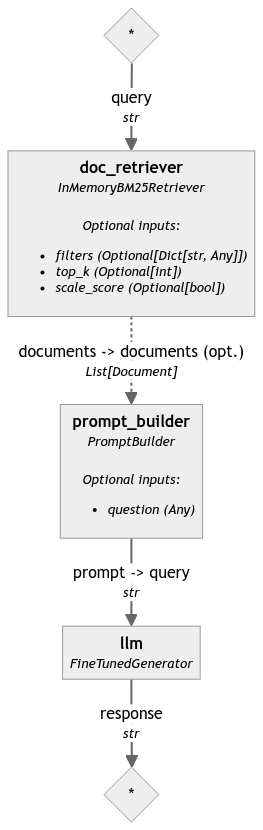

In [19]:
prompt_template = """
    Given these documents, answer the question.\nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{question}}
    \nAnswer:
"""

prompt_builder = PromptBuilder(template=prompt_template)

rag_pipeline = Pipeline()

rag_pipeline.add_component(name="doc_retriever", instance=doc_retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component(name="llm", instance= FineTunedGenerator())

rag_pipeline.connect("doc_retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

In [20]:
question = "I am analyzing 321 genome but not getting the alignment file. \
I have tried different versions of ROARY and with varying changes in the maximum number of clusters. \
Can you help me with it?"

result = rag_pipeline.run(
    {"doc_retriever": {"query": question}},
    {"prompt_builder": {"question": question}}
)

print(result['llm']['response'])

Ranking by BM25...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5044/5044 [00:00<00:00, 9916.09 docs/s]


Generating text by fine-tuned LLM...
Encoding query...
Generating response...


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.37 GiB (GPU 0; 31.74 GiB total capacity; 9.29 GiB already allocated; 4.87 GiB free; 11.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
'''
#result = pipeline.run(data={"retriever": {"query": "How to make Galaxy pull request?"}})

#print(result["retriever"]["documents"])

#preprocessed_docs = processor.process(docs)
#document_store = InMemoryDocumentStore(use_bm25=True)
#document_store.write_documents(preprocessed_docs)
#retriever = BM25Retriever(document_store, top_k=4)

# a good Question Answering template, adapted for the instruction format
# (https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1)

qa_template = PromptTemplate(prompt=
  """<s>[INST] Using the information contained in the context, answer the question (using a maximum of two sentences).
  If the answer cannot be deduced from the context, answer \"I don't know.\"
  Context: {join(documents)};
  Question: {query}
  [/INST]""")

#model_name = "NousResearch/Llama-2-7b-chat-hf"
#model_name = "mistralai/Mistral-7B-Instruct-v0.1"
prompt_node = PromptNode(
    model_name_or_path=peft_model,
    api_key=HF_TOKEN,
    default_prompt_template=qa_template,
    max_length=5500,
    model_kwargs={"model_max_length":8000}
)

rag_pipeline = Pipeline()
rag_pipeline.add_node(component=retriever, name="retriever", inputs=["Query"])
rag_pipeline.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])
pipeline.add_component("llm", generator)

from pprint import pprint
print_answer = lambda out: pprint(out["results"][0].strip())

print_answer(rag_pipeline.run(query="I would suggest installing the refseq_masher package. I checked earlier, and found it in the toolshed. \
Please, this package will help a lot."))'''